In [1]:
from stations.models import Measurement, Prediction, Station
from asgiref.sync import sync_to_async
import pandas as pd
import matplotlib
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
#import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
import pickle
import glob

from geolomasexp.configuration import LSTMTrainingScriptConfig

from geolomasexp.data import read_time_series_from_csv
from geolomasexp.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from geolomasexp.model_hyperopt import (
    get_lstm_nnet_opt
)
from geolomasexp.model import (train_val_test_split)

from geolomasexp.model import predict_with_model


import ipdb



Using TensorFlow backend.
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

In [2]:
def read_time_series_from_db(
            sensor='A620',
            date_col='date',
            hr_col='hr',
            min_col='minute',
            numeric_var='temperature',
            sensor_var='inme',  # TODO : change this for station_code in all the script
            date_since=None,
            which_minutes = [0,15,30,45]
            ):
        # get the station (sensor)
        #station = Station.objects.get(code=sensor)
        # get all the measurements from this station
        measurements = Measurement.objects.filter(station=Station.objects.get(
            code=sensor).id)
        if date_since is not None:
            measurements = measurements.filter(datetime__gte=date_since)

        print(
            'Measurements to read from database for sensor {} with query \n{}'.
            format(sensor, measurements.query))
        # get a dataframe from the measurements
        dataset = pd.DataFrame(
            list(measurements.values('datetime', 'attributes')))
        print('Dataset from database of shape {}'.format(
            dataset.shape))
        # parse datetime column to get sepearae date, hr and minute columns
        dataset[date_col] = dataset.datetime.dt.date
        dataset[hr_col] = dataset.datetime.dt.hour
        dataset[min_col] = dataset.datetime.dt.minute
        # get the numeric var column parsing the json
        dataset[numeric_var] = dataset.attributes.apply(
            lambda x: x[numeric_var])
        dataset[sensor_var] = sensor

        # sort and re-index before returning
        dataset.sort_values([date_col, hr_col,min_col], inplace=True, ascending=True)
        dataset.reset_index(inplace=True)

        return dataset.loc[dataset.minute.isin(which_minutes)]

In [26]:
dataframe_temp = read_time_series_from_db(which_minutes=[0])
dataframe_temp

Measurements to read from database for sensor A620 with query 
SELECT "stations_measurement"."id", "stations_measurement"."datetime", "stations_measurement"."station_id", "stations_measurement"."attributes" FROM "stations_measurement" WHERE "stations_measurement"."station_id" = 2
Dataset from database of shape (201600, 2)


,index,datetime,attributes,date,hr,minute,temperature,inme
0,0,2011-01-01 00:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,0,0,0.0,A620
4,1,2011-01-01 01:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,1,0,0.0,A620
8,2,2011-01-01 02:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,2,0,0.0,A620
12,3,2011-01-01 03:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,3,0,0.0,A620
16,4,2011-01-01 04:00:00+00:00,"{'pm25': 0.0, 'humidity': 0.0, 'pressure': 0.0...",2011-01-01,4,0,0.0,A620
...,...,...,...,...,...,...,...,...
201580,201451,2016-09-30 19:00:00+00:00,"{'pm25': 0.0, 'humidity': 81.0, 'pressure': 10...",2016-09-30,19,0,20.7,A620
201584,201452,2016-09-30 20:00:00+00:00,"{'pm25': 0.0, 'humidity': 77.0, 'pressure': 10...",2016-09-30,20,0,21.1,A620
201588,201453,2016-09-30 21:00:00+00:00,"{'pm25': 0.4, 'humidity': 88.0, 'pressure': 10...",2016-09-30,21,0,19.4,A620
201592,201454,2016-09-30 22:00:00+00:00,"{'pm25': 0.0, 'humidity': 90.0, 'pressure': 10...",2016-09-30,22,0,19.4,A620


In [27]:
from geolomasexp.feature import get_dataset_from_series, get_interest_variable
time_series_dset = get_interest_variable(dataframe_temp, 'inme',
                                                 'date', 'hr','temperature',
                                                 'A620')
time_series_dset.head()

temperature
date       hr             
2011-01-01 0           0.0
           1           0.0
           2           0.0
           3           0.0
           4           0.0

In [28]:
from geolomasexp.feature import series_to_supervised

#model_package_name = '../../geolomas-exp/models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_22:26:47.model'
#model_package_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_23:09:03.model'
model_package_name = '../models/esp:100_eps:1000_loss:mean_absolute_error_opt:adam_pstps:24_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-28_02:57:24.model'

with open(model_package_name, 'rb') as file_pi:
    model_package = pickle.load(file_pi)
    
scaler = model_package['scaler']


# obtenemos los valores como una matriz
values = time_series_dset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)
scaled = pd.DataFrame(scaled,columns=time_series_dset.columns)# frame as supervised learning

reframed = series_to_supervised(scaled, 24, 1)



In [29]:
from geolomasexp.model import (build_lstm_nnet, eval_regression_performance,
                               fit_model, train_val_test_split)

dataset_splits = train_val_test_split(reframed, 24,1, 'temperature')
dataset_splits

Sampleamos datasets de futuro a pasado
(30225, 24) 30225 (30225,)
(30225, 24, 1) (30225,) (10075, 24, 1) (10075,) (10076, 24, 1) (10076,)


{'trainset': {'X': array([[[0.67228913],
          [0.67469877],
          [0.67951804],
          ...,
          [0.6096385 ],
          [0.64096385],
          [0.6216867 ]],
  
         [[0.67469877],
          [0.67951804],
          [0.67228913],
          ...,
          [0.64096385],
          [0.6216867 ],
          [0.6337349 ]],
  
         [[0.67951804],
          [0.67228913],
          [0.62409633],
          ...,
          [0.6216867 ],
          [0.6337349 ],
          [0.6433734 ]],
  
         ...,
  
         [[0.59999996],
          [0.58072287],
          [0.5686747 ],
          ...,
          [0.539759  ],
          [0.52048194],
          [0.53012043]],
  
         [[0.58072287],
          [0.5686747 ],
          [0.5614457 ],
          ...,
          [0.52048194],
          [0.53012043],
          [0.48915657]],
  
         [[0.5686747 ],
          [0.5614457 ],
          [0.5493975 ],
          ...,
          [0.53012043],
          [0.48915657],
          [0.489

In [30]:
dset = dataset_splits['trainset']

X = dset['X']
y = dset['y']

X[0,:].shape

y[0:24].reshape(1,24)
scaler.inverse_transform(y[0:24].reshape(1,24))

array([[25.4     , 25.8     , 26.5     , 25.099998, 25.      , 23.7     ,
        22.399998, 21.5     , 20.1     , 20.4     , 20.200003, 20.1     ,
        19.8     , 18.6     , 17.9     , 17.6     , 17.5     , 16.8     ,
        17.5     , 18.8     , 20.700003, 23.7     , 25.8     , 26.1     ]],
      dtype=float32)

In [32]:
from sklearn.metrics import mean_absolute_error , max_error
import numpy as np

dset = dataset_splits['trainset']

X = dset['X']
y = dset['y']

#y = y.reshape((len(y), 1))
#yhat = model.predict(X)

future_steps = 24

maes = []
maxes = []

#model_package_name = '../../geolomas-exp/models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_22:26:47.model'
#model_package_name = '../models/esp:100_eps:1000_loss:mean_absolute_error_opt:adam_pstps:24_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-28_02:57:24.model'


#with open(model_package_name, 'rb') as file_pi:
#    model_package = pickle.load(file_pi)
    
#scaler = model_package['scaler']



#for i in range(X.shape[0]-future_steps):
for i in np.random.randint(0,X.shape[0]-future_steps-1,5):    
    try:
        # do we need to add the first dimension 
        datapoint = X[i,:,:]
        print('datapoint {}'.format(datapoint))
        true = scaler.inverse_transform(y[i:i+future_steps].reshape(1,future_steps))
        print('true {}'.format(true))
        preds,_ = predict_with_model(datapoint,model_package_name,future_steps)
        pred_list = []
        for step in preds:
            pred_list.append(np.float64(step[0][0]))
        pred = np.array([pred_list])
        print('pred {}'.format(pred))
        mae_ = mean_absolute_error(true[0],pred[0])
        maes.append(mae_)
        print('mae {}'.format(mae_))
        maxe_ = max_error(true[0],pred[0])
        maxes.append(maxe_)
        print('maxe {}'.format(maxe_))
    except Exception as e:
        print('Exception {}'.format(e))



datapoint [[0.6698795 ]
 [0.7012048 ]
 [0.71807224]
 [0.7204819 ]
 [0.7084337 ]
 [0.68674695]
 [0.6385542 ]
 [0.62891567]
 [0.6168674 ]
 [0.61204815]
 [0.6096385 ]
 [0.6072289 ]
 [0.6072289 ]
 [0.5951807 ]
 [0.5903614 ]
 [0.58072287]
 [0.58554214]
 [0.5759036 ]
 [0.57108426]
 [0.57349396]
 [0.5759036 ]
 [0.5879518 ]
 [0.57108426]
 [0.5975903 ]]
true [[24.3      23.7      23.300001 25.       25.200003 25.5      25.600002
  25.200003 24.3      23.6      23.7      23.7      21.600002 21.7
  21.8      21.8      21.7      21.600002 21.5      21.600002 21.200003
  21.7      22.799997 23.5     ]]
pred [[23.96042061 30.99720001 33.19526672 34.29727173 35.44558716 36.11928177
  36.6841011  37.1182251  37.46864319 37.77130508 37.99884033 38.20820618
  38.40118408 38.57260513 38.68789673 38.80444717 38.92961121 39.03258133
  39.11476517 39.19804001 39.28677368 39.33309174 39.34440231 39.40524292]]
mae 13.85225542386373
maxe 18.08677101135254
datapoint [[0.49397588]
 [0.51084334]
 [0.57108426]
 [0

In [ ]:
print(np.mean(maes))
print(np.mean(maxes))

In [20]:
print(np.mean(maes))
print(np.mean(maxes))

5.375785764058431
8.216272926330566


In [17]:
np.random.randint(0,100,3)

array([ 8, 57, 14])

In [35]:
def get_database_data(djmodel = Prediction,sensor = 'A620',numeric_vars = ['temperature'],last_n_steps = -1):
    stat_id = Station.objects.get(code=sensor).id
    if last_n_steps > 0:
        records = djmodel.objects.filter(station=stat_id).order_by('-datetime')[:last_n_steps]
    else :
        records = djmodel.objects.filter(station=stat_id)
    dataset = pd.DataFrame(list(records.values('datetime', 'attributes')))
    dataset['date'] = dataset.datetime.dt.date
    dataset['hr'] = dataset.datetime.dt.hour
    dataset['minute'] = dataset.datetime.dt.minute
    # get the numeric var column parsing the json
    for numeric_var in numeric_vars:
        dataset[numeric_var] = dataset.attributes.apply(lambda x: x[numeric_var])
    # sort and re-index before returning
    dataset.sort_values(['date', 'hr','minute'], inplace=True, ascending=True)
    dataset.reset_index(inplace=True)
    return dataset

predictions_df = get_database_data(numeric_vars = ['temperature','humidity'])
predictions_df.sort_values('datetime',ascending = True,inplace = True)
predictions_df.set_index('datetime',inplace=True)
predictions_df

,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-10-01 00:45:00+00:00,0,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,0,45,30.213940,0
2016-10-01 01:45:00+00:00,1,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,1,45,30.214190,0
2016-10-01 02:45:00+00:00,2,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,2,45,30.213863,0
2016-10-01 03:45:00+00:00,3,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,3,45,30.212488,0
2016-10-01 04:45:00+00:00,4,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,4,45,30.211885,0
2016-10-01 05:45:00+00:00,5,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,5,45,30.211706,0
2016-10-01 06:45:00+00:00,6,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,6,45,30.211325,0
2016-10-01 07:45:00+00:00,7,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,7,45,30.211201,0
2016-10-01 08:45:00+00:00,8,"{'pm25': 0, 'humidity': 0, 'pressure': 0, 'win...",2016-10-01,8,45,30.211514,0


In [36]:
measurement_df = get_database_data(Measurement,numeric_vars = ['temperature','humidity'],last_n_steps=30)
measurement_df.sort_values('datetime',ascending = True,inplace = True)
measurement_df.set_index('datetime',inplace=True)
measurement_df

,index,attributes,date,hr,minute,temperature,humidity
datetime,,,,,,,
2016-09-30 16:30:00+00:00,29,"{'pm25': 0.6, 'humidity': 85.6, 'pressure': 10...",2016-09-30,16,30,21.1,85.6
2016-09-30 16:45:00+00:00,28,"{'pm25': -0.9, 'humidity': 84.1, 'pressure': 1...",2016-09-30,16,45,19.6,84.1
2016-09-30 17:00:00+00:00,27,"{'pm25': 0.0, 'humidity': 78.0, 'pressure': 10...",2016-09-30,17,0,21.1,78.0
2016-09-30 17:15:00+00:00,26,"{'pm25': -0.3, 'humidity': 77.7, 'pressure': 1...",2016-09-30,17,15,20.8,77.7
2016-09-30 17:30:00+00:00,25,"{'pm25': 0.6, 'humidity': 78.6, 'pressure': 10...",2016-09-30,17,30,21.7,78.6
2016-09-30 17:45:00+00:00,24,"{'pm25': -0.9, 'humidity': 77.1, 'pressure': 1...",2016-09-30,17,45,20.2,77.1
2016-09-30 18:00:00+00:00,23,"{'pm25': 0.0, 'humidity': 75.0, 'pressure': 10...",2016-09-30,18,0,21.5,75.0
2016-09-30 18:15:00+00:00,22,"{'pm25': -0.3, 'humidity': 74.7, 'pressure': 1...",2016-09-30,18,15,21.2,74.7
2016-09-30 18:30:00+00:00,21,"{'pm25': 0.6, 'humidity': 75.6, 'pressure': 10...",2016-09-30,18,30,22.1,75.6


In [37]:
plot_df = pd.concat([predictions_df[['temperature']],measurement_df[['temperature']]])
plot_df.sort_values('datetime',ascending = True,inplace= True)

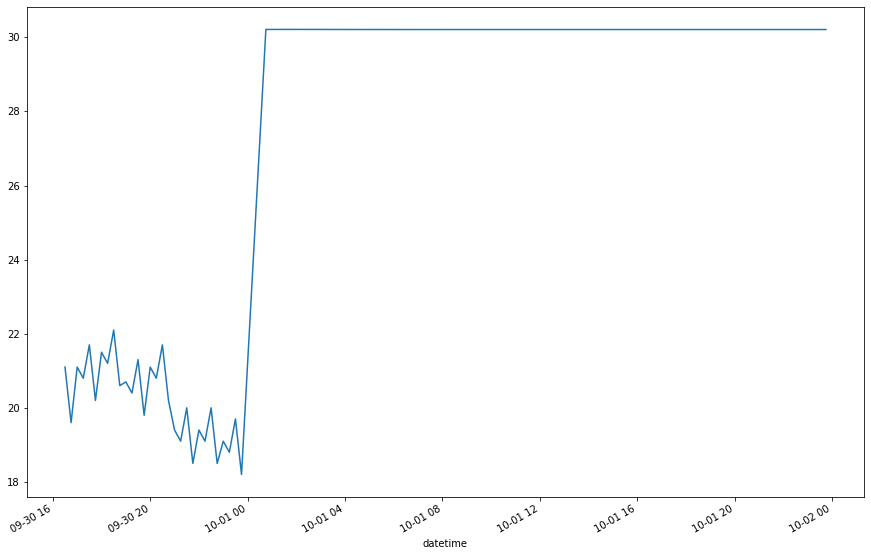

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
plot_df.temperature.plot()

Traceback (most recent call last):
  File "/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py", line 305, in _convert_1d
    values = tools.to_datetime(values)
  File "/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/pandas/core/tools/datetimes.py", line 754, in to_datetime
    result = convert_listlike(arg, format)
  File "/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/pandas/core/tools/datetimes.py", line 447, in _convert_listlike_datetimes
    allow_object=True,
  File "/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py", line 1854, in objects_to_datetime64ns
    require_iso8601=require_iso8601,
  File "pandas/_libs/tslib.pyx", line 481, in pandas._libs.tslib.array_to_datetime
  File "pandas/_libs/tslib.pyx", line 703, in pandas._libs.tslib.array_to_da

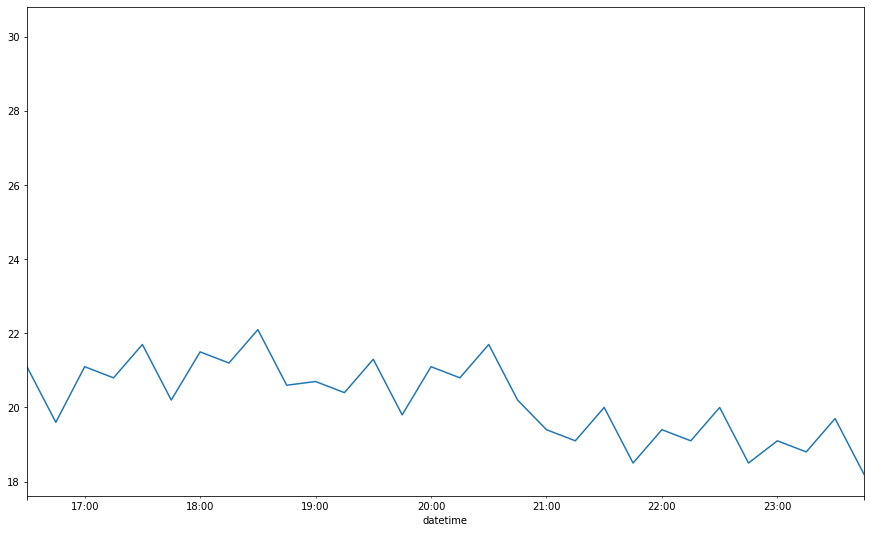

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.temperature.plot()
predictions_df.temperature[:30].plot()
plt.show()

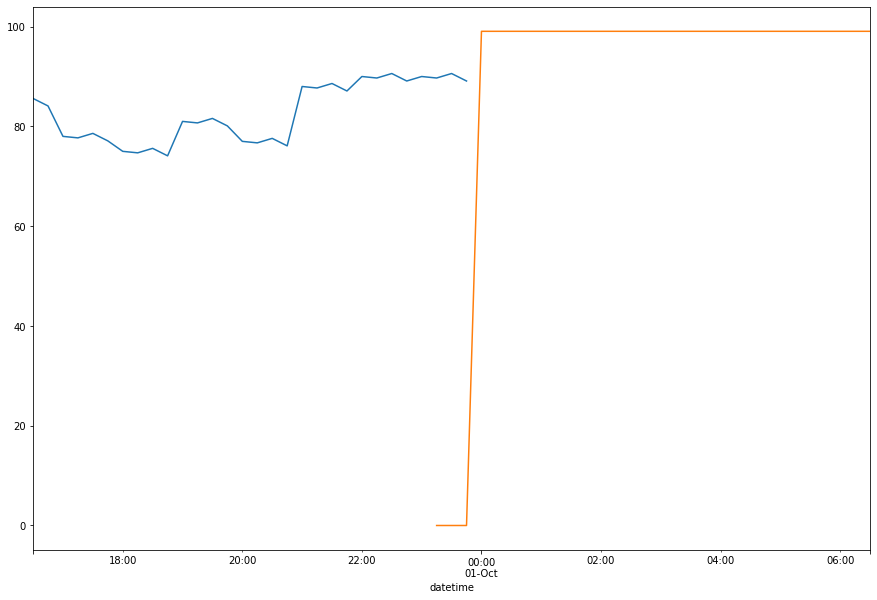

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.humidity.plot()
predictions_df.humidity[:30].plot()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,10))
measurement_df.sort_values('datetime',ascending = True).set_index('datetime').temperature.plot()
predictions_df.sort_values('datetime',ascending = True).set_index('datetime').temperature[:20].plot()
plt.show()

In [45]:

out_model_name = glob.glob('../models/*_hyperopt_model_*.hdf5')[-1]
out_model_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_hyperopt_model_2020-04-20_23:16:42.hdf5'
print(out_model_name)
#out_model_name = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_model_2020-02-25_10:13:29.hdf5'
model_hyper = load_model(out_model_name)
print(model_hyper.summary())


../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_hyperopt_model_2020-04-20_23:16:42.hdf5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 16)             1152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_7 (LS

In [67]:
model_pckg_filename = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-20_23:16:42.model'
with open(model_pckg_filename, 'rb') as file_pi:
    model_package = pickle.load(file_pi)
    
model = model_package['model']
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 16)             1152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 16)             2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)               

In [64]:
import numpy as np
scaler = model_package['scaler']
datapoint = measurement_df.temperature.values[:8]
print(datapoint)
for step in range(10) :
    X = np.array(datapoint[-8:]).reshape(1,model.input_shape[1],model.input_shape[2])
    y = scaler.inverse_transform(model.predict(X))
    datapoint = np.append(datapoint,y)
print(datapoint)

[21.1 19.6 21.1 20.8 21.7 20.2 21.5 21.2]
[21.1        19.6        21.1        20.8        21.7        20.2
 21.5        21.2        82.95090485 82.99260712 83.05224609 83.0941925
 83.12081146 83.13577271 83.14514923 83.15190887 83.15369415 83.15371704]


In [98]:
np.array(datapoint[-8:]).reshape(1,model.input_shape[1],model.input_shape[2]).shape

(1, 8, 1)

In [66]:
measurement_df.temperature.values[:8+10]

array([21.1, 19.6, 21.1, 20.8, 21.7, 20.2, 21.5, 21.2, 22.1, 20.6, 20.7,
       20.4, 21.3, 19.8, 21.1, 20.8, 21.7, 20.2])

In [44]:
data_csv = pd.read_csv('../../geolomas-exp/data/meteorologico/A620_temp.csv')
data_csv

,inme,date,hr,temperature
0,A620,2006-09-25,0,0.0
1,A620,2006-09-25,1,0.0
2,A620,2006-09-25,2,0.0
3,A620,2006-09-25,3,0.0
4,A620,2006-09-25,4,0.0
...,...,...,...,...
160579,A620,2016-09-30,21,20.7
160580,A620,2016-09-30,22,19.4
160581,A620,2016-09-30,22,20.6
160582,A620,2016-09-30,23,19.1


In [52]:
from geolomasexp.model import predict_with_model
start_point = -1 * 24 * 10
steps_train = 8
datapoint = data_csv.temperature.values[start_point:start_point+steps_train]
datapoint

array([18.8, 21.6, 18.6, 21.4, 18.5, 20.6, 18.3, 20.1])

In [67]:
model_package_name = '../../geolomas-exp/models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_22:26:47.model'
#model_package_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_23:09:03.model'
pred,_ = predict_with_model(datapoint,model_package_name,24)
pred

/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[array([[30.2141]], dtype=float32),
 array([[30.213383]], dtype=float32),
 array([[30.213684]], dtype=float32),
 array([[30.212234]], dtype=float32),
 array([[30.211843]], dtype=float32),
 array([[30.211504]], dtype=float32),
 array([[30.211315]], dtype=float32),
 array([[30.211306]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211515]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32)]

In [57]:
data_csv.temperature.values[start_point+steps_train-1:start_point+steps_train+24]

array([20.1, 18.3, 19.1, 18.2, 20.7, 17.7, 20.9, 17.9, 20.9, 17.9, 20.4,
       18.3, 20.8, 19.3, 19.8, 20.1, 20.8, 21.4, 21.3, 22.6, 21.6, 23.5,
       21.6, 24.5, 21.8])

In [64]:
datapoint_db = dataframe_temp.temperature.values[start_point:start_point+steps_train]
datapoint_db

array([23.9, 23.6, 24.5, 23. , 25.2, 24.9, 25.8, 24.3])

In [66]:
model_package_name = '../../geolomas-exp/models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_22:26:47.model'
#model_package_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_23:09:03.model'
pred,_ = predict_with_model(datapoint_db,model_package_name,24)
pred

/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[array([[30.21068]], dtype=float32),
 array([[30.21229]], dtype=float32),
 array([[30.2117]], dtype=float32),
 array([[30.211958]], dtype=float32),
 array([[30.211657]], dtype=float32),
 array([[30.211678]], dtype=float32),
 array([[30.211576]], dtype=float32),
 array([[30.211441]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32),
 array([[30.211514]], dtype=float32)]

In [71]:
import numpy as np
datapoint_db.shape
X = np.array(datapoint_db).reshape(1,8,1)
X

array([[[23.9],
        [23.6],
        [24.5],
        [23. ],
        [25.2],
        [24.9],
        [25.8],
        [24.3]]])

In [75]:
model_package_name = '../../geolomas-exp/models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_22:26:47.model'
#model_package_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:8_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2][2][0.1, 0.3]1_model_hyperopt_package_2020-04-22_23:09:03.model'

with open(model_package_name, 'rb') as file_pi:
    model_package = pickle.load(file_pi)

model = model_package['model']

yhat = model.predict(X)

scaler = model_package['scaler']

print(yhat)

inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)




/home/munshkr/.local/share/virtualenvs/geolomas-back-12XYk-xP/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[[0.755267]]
[[30.21068]]


In [ ]:
'''
# por que reshapeamos aca?
test_X_2d = test_X.reshape((test_X.shape[0], n_past_steps*n_features))
train_X_2d = train_X.reshape((train_X.shape[0], n_past_steps*n_features))
# invert scaling for forecast
# test
# Por que lo que hace es armar una matrix n_samples,6 con una fila por cada datapoint con la primera columna con la prediccion y las otras las features?
inv_yhat = concatenate((yhat, test_X_2d[:, -1*(n_features-1):]), axis=1)
# afecta en algo aplicar invers_stransform sobre una sola columna que con tra la matriz?
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# train
tr_inv_yhat = concatenate((tr_yhat, train_X_2d[:, -1*(n_features-1):]), axis=1)
tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
tr_inv_yhat = tr_inv_yhat[:,0]

# invert scaling for actual
#test
test_y_2d = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_2d, test_X_2d[:, -1*(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#train
train_y_2d = train_y.reshape((len(train_y), 1))
tr_inv_y = concatenate((train_y_2d, train_y_2d[:, -1*(n_features-1):]), axis=1)
tr_inv_y = scaler.inverse_transform(tr_inv_y)
tr_inv_y = tr_inv_y[:,0]
'''

In [50]:
aa = [1,2,3,4,5,6,7,8,9,10]
aa[-5:]

[6, 7, 8, 9, 10]

In [34]:
Prediction.objects.all()[:3]

<QuerySet [<Prediction: 2016-10-01 00:45:00+00:00 CAMPOS (A620) - Campos dos Goytacazes :: {'pm25': 0, 'humidity': 0, 'pressure': 0, 'wind_speed': 0, 'temperature': 30.213939666748047, 'precipitation': 0, 'wind_direction': 0}>, <Prediction: 2016-10-01 01:45:00+00:00 CAMPOS (A620) - Campos dos Goytacazes :: {'pm25': 0, 'humidity': 0, 'pressure': 0, 'wind_speed': 0, 'temperature': 30.214189529418945, 'precipitation': 0, 'wind_direction': 0}>, <Prediction: 2016-10-01 02:45:00+00:00 CAMPOS (A620) - Campos dos Goytacazes :: {'pm25': 0, 'humidity': 0, 'pressure': 0, 'wind_speed': 0, 'temperature': 30.213863372802734, 'precipitation': 0, 'wind_direction': 0}>]>